<a href="https://colab.research.google.com/github/ducanhho2296/CycleGAN-using-TF/blob/main/Cycle_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-qqyqy3uz
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-qqyqy3uz
  Created wheel for tensorflow-examples: filename=tensorflow_examples-88287d08f9fe73ef20bbea3cc004440b1c7299f9_-py3-none-any.whl size=299303 sha256=2ee4157fa1af9923c80105c8858030113b357f1e532c8de4ec98688414aa7a85
  Stored in directory: /tmp/pip-ephem-wheel-cache-069payzk/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/i

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

In [4]:
dataset, metadata = tfds.load('cycle_gan/horse2zebra', with_info=True, 
                              as_supervised=True)
train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteP4FNAR/cycle_gan-trainA.tfrecord


  0%|          | 0/1067 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteP4FNAR/cycle_gan-trainB.tfrecord


  0%|          | 0/1334 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteP4FNAR/cycle_gan-testA.tfrecord


  0%|          | 0/120 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incompleteP4FNAR/cycle_gan-testB.tfrecord


  0%|          | 0/140 [00:00<?, ? examples/s]

Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0. Subsequent calls will reuse this data.


In [5]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [6]:
def random_crop(image):
  cropped_image = tf.image.random_crop(image,
                                       size = [IMG_HEIGHT, IMG_WIDTH, 3])
  return cropped_image

In [7]:
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image /127.5) - 1
  return image

In [8]:
def random_jitter(image):
  image = tf.image.resize(image, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  image = random_crop(image)

  image = tf.image.random_flip_left_right(image)
  return image

In [9]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [10]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [11]:
train_horses = train_horses.cache().map(preprocess_image_train, 
                                        num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_zebras = train_zebras.cache().map(preprocess_image_train, 
                                        num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_horses = test_horses.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_zebras = test_zebras.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)


In [12]:
sample_horse =next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

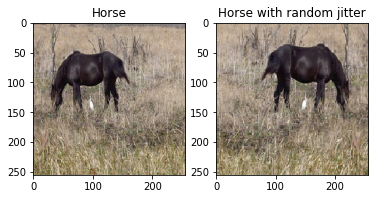

In [13]:
plt.subplot(121)
plt.title('Horse')
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Horse with random jitter')
plt.imshow(random_jitter(sample_horse[0] * 0.5 + 0.5))

In [14]:
OUTPUT_CHANNELS = 3

gen_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
gen_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

dis_x = pix2pix.discriminator(norm_type='instancenorm', target= False)
dis_y = pix2pix.discriminator(norm_type='instancenorm', target= False)

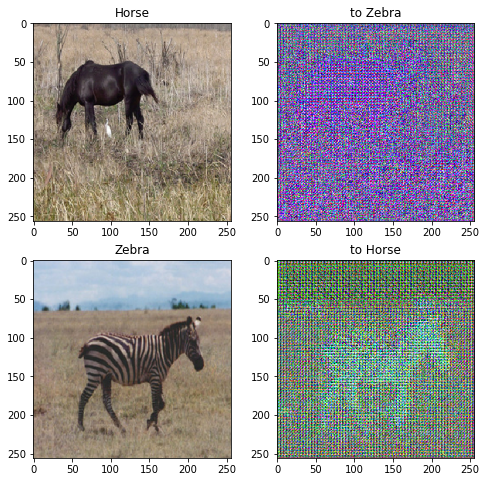

In [15]:
to_zebra = gen_g(sample_horse)
to_horse = gen_f(sample_zebra)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ['Horse', 'to Zebra', 'Zebra', 'to Horse']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

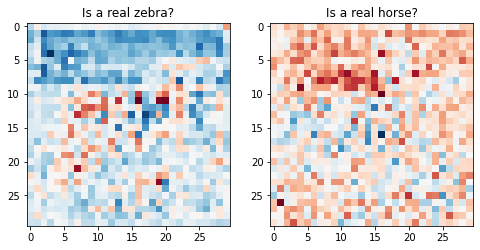

In [16]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real zebra?')
plt.imshow(dis_y(sample_zebra)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real horse?')
plt.imshow(dis_x(sample_horse)[0, ..., -1], cmap='RdBu_r')

plt.show()

In [17]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryFocalCrossentropy(from_logits=True)

In [18]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)
  generated_loss = loss_obj(tf.zeros_like(generated), generated)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss * 0.5

In [19]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [20]:
def calc_cycle_loss(real_img, cycled_img):
  loss1 = tf.reduce_mean(tf.abs(real_img - cycled_img))
  return LAMBDA * loss1

In [21]:
def identity_loss(real_img, same_img):
  loss = tf.reduce_mean(tf.abs(real_img - same_img))
  return LAMBDA * loss * 0.5

In [22]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [23]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(gen_g=gen_g,
                           gen_f=gen_f,
                           dis_x=dis_x,
                           dis_y=dis_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [24]:
EPOCHS = 1 #time to train are too slow even using GPUs, so I change to an minimum epoch to see what will come out of output

In [25]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [26]:
@tf.function
def train_step(real_x, real_y):
  with tf.GradientTape(persistent=True) as tape:
    fake_y = gen_g(real_x, training=True)
    cycled_x = gen_f(fake_y, training=True)
    
    fake_x = gen_f(real_y, training=True)
    cycled_y = gen_g(fake_x, training=True)

    same_x = gen_f(real_x, training=True)
    same_y = gen_g(real_y, training=True)

    #disciminators
    disc_real_x = dis_x(real_x, training=True)
    disc_real_y = dis_y(real_y, training=True)

    disc_fake_x = dis_x(fake_x, training=True)
    disc_fake_y = dis_y(fake_y, training=True)

    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    
    total_cycle_loss = calc_cycle_loss(real_x, 
                                       cycled_x) + calc_cycle_loss(real_y, 
                                                                   cycled_y)
    
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    #update gradients with tape()
    generator_g_gradients = tape.gradient(total_gen_g_loss,
                                          gen_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        gen_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            dis_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            dis_y.trainable_variables)
  

  #optimize
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            gen_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            gen_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                dis_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                dis_y.trainable_variables))

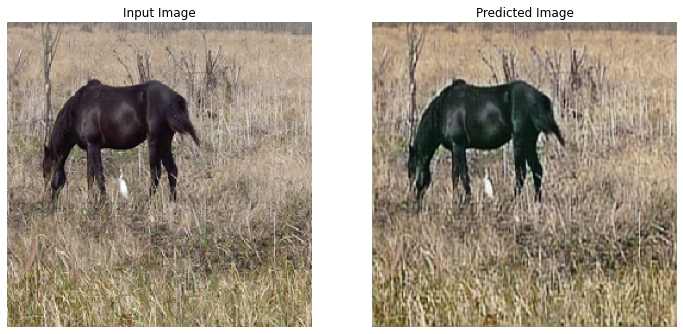

Time taken for epoch 1 is 474.80697894096375 sec



In [27]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(gen_g, sample_horse)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))